In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
columns = ['year', 'month', 'day', 'decimal date', 'molfrac', 'days', '1 yr ago', '10 yrs ago', 'since 1800']
df=pd.read_csv('co2_weekly_mlo.txt',sep="\s+",comment="#",names=columns,na_values=-999.99)

In [3]:
df['date']=pd.to_datetime(df[['year','month','day']])

In [4]:
df.set_index('date',inplace=True)

In [5]:
co2=df['molfrac'].asfreq('W')

Text(0, 0.5, 'co2')

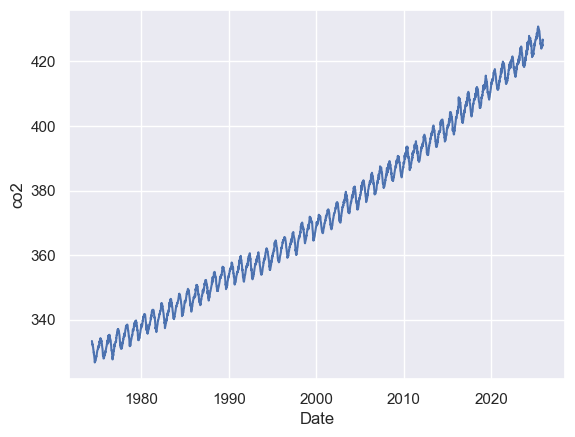

In [6]:
co2=co2.interpolate()

plt.plot(co2)
plt.xlabel('Date')
plt.ylabel('co2')

In [7]:
train_size=int(len(co2)*0.7)
train,test=co2.iloc[:train_size],co2.iloc[train_size:]

In [8]:
test

date
2010-06-06    392.99
2010-06-13    392.10
2010-06-20    391.86
2010-06-27    391.36
2010-07-04    390.77
               ...  
2025-10-19    425.20
2025-10-26    425.26
2025-11-02    424.78
2025-11-09    426.80
2025-11-16    426.55
Freq: W-SUN, Name: molfrac, Length: 807, dtype: float64

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima import auto_arima

# ARIMA 

In [68]:
# ARIMA
arima_model = SARIMAX(train, order=(1,0,0),trend='c',enforce_stationarity=False, enforce_invertibility=False)## trend='n','c','t','ct'
arima_fit = arima_model.fit(disp=False)

# SARIMA

In [207]:
# SARIMA m=52 for weekly
# pdq PDQm
sarima_model=SARIMAX(train,order=(1,0,0),seasonal_order=(1,0,1,52),enforce_stationarity=False, enforce_invertibility=False)

In [208]:
sarima_fit=sarima_model.fit(disp=False)

# ARIMAX

In [116]:
# ARIMAX (add time trend as exogenousy)

In [117]:
train_exog=np.arange(len(train)).reshape(-1,1)
test_exog=np.arange(len(train),len(co2)).reshape(-1,1)

In [190]:
arimax_model=SARIMAX(train,exog=train_exog,order=(1,1,1),seasonal_order=(1,1,1,52),trend='t',enforce_stationarity=False, enforce_invertibility=False)
arimax_fit=arimax_model.fit(disp=False)

In [191]:
# Forecast for test length

In [192]:
steps=len(test)

# ETS Model

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [77]:
# ['add','mul'], ['add','mul']
ets=ExponentialSmoothing(train,trend='add',seasonal='mul',seasonal_periods=52,use_boxcox=True)
ets_fit=ets.fit(optimized=True,remove_bias=False)
ets_pred=ets_fit.forecast(len(test))

In [209]:
arima_pred  = arima_fit.forecast(steps=steps)
sarima_pred = sarima_fit.forecast(steps=steps)

In [210]:
arimax_pred = arimax_fit.forecast(steps=steps, exog=test_exog)

In [211]:
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

In [212]:
def evaluate(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae  = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    r2  = r2_score(true, pred)

    return rmse, mae, mape,r2

In [213]:
results = {
    "ARIMA"  : evaluate(test, arima_pred),
    "SARIMA" : evaluate(test, sarima_pred),
    "ARIMAX" : evaluate(test, arimax_pred),
    "ETS" :evaluate(test,ets_pred)
}
metrics_df = pd.DataFrame(results, index=["RMSE","MAE","MAPE","R2_Score"]).T
print(metrics_df)

            RMSE       MAE      MAPE  R2_Score
ARIMA   3.162124  2.583074  0.637524  0.922783
SARIMA  1.655579  1.398074  0.344563  0.978833
ARIMAX  0.893128  0.698668  0.170191  0.993840
ETS     3.363112  2.743933  0.661536  0.912655


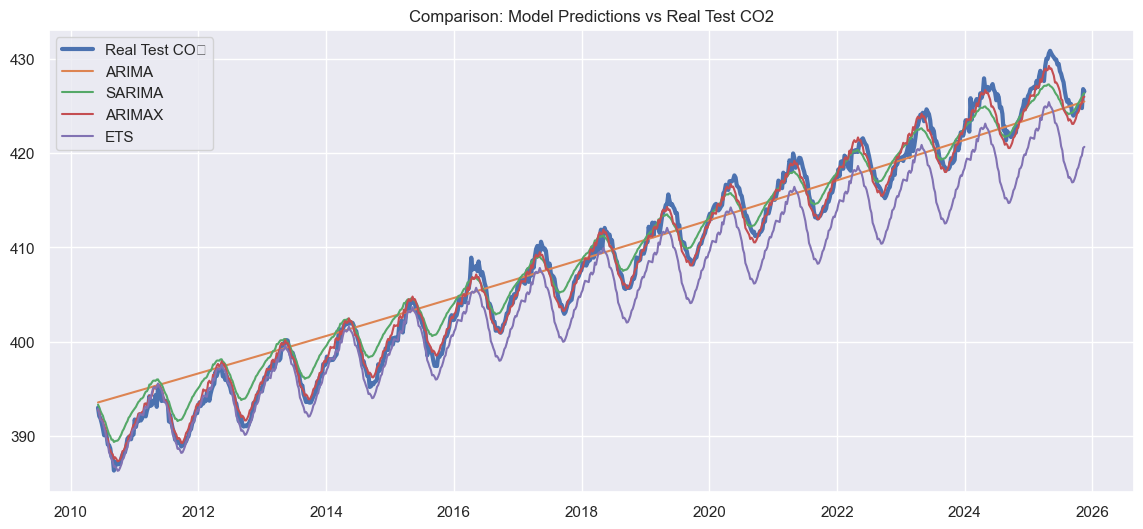

In [214]:
plt.figure(figsize=(14,6))
# plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Real Test CO₂", linewidth=3)
plt.plot(test.index, arima_pred, label="ARIMA")
plt.plot(test.index, sarima_pred, label="SARIMA")
plt.plot(test.index, arimax_pred, label="ARIMAX")
plt.plot(test.index, ets_pred, label="ETS")
plt.legend()
plt.title("Comparison: Model Predictions vs Real Test CO2")
plt.show()

# Making future forecasts

- we will use SARIMAX Model and retrain it on all the data to make forecasts

In [333]:
data_exog=np.arange(len(co2)).reshape(-1,1)
arimax_model=SARIMAX(co2,exog=data_exog,order=(5,1,2),seasonal_order=(1,1,1,52),trend='t',enforce_stationarity=False, enforce_invertibility=False)
arimax_fit=arimax_model.fit(disp=False)

In [362]:
future_steps=100
future_exog=np.arange(len(co2),len(co2)+future_steps).reshape(-1,1)

In [510]:
future_arimax = arimax_fit.forecast(steps=future_steps, exog=future_exog)

In [515]:
future_arimax_ci = arimax_fit.get_forecast(steps=future_steps, exog=future_exog).conf_int(alpha=0.05)

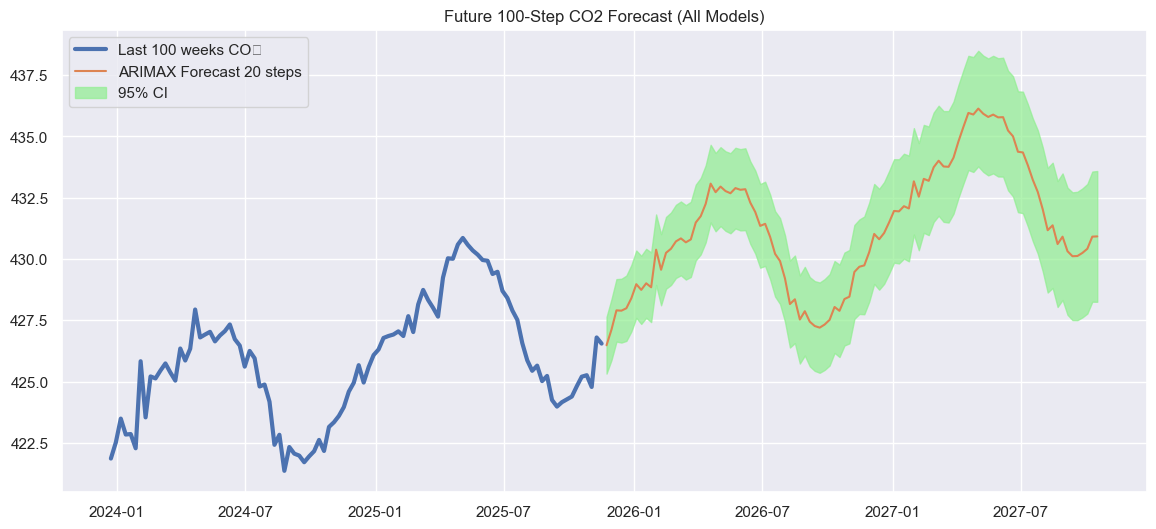

In [533]:
plt.figure(figsize=(14,6))
plt.plot(co2[-100:], label="Last 100 weeks CO₂", linewidth=3)
plt.plot( future_arimax, label="ARIMAX Forecast 20 steps")
plt.fill_between(x=future_arimax.index,y1=future_arimax_ci.iloc[:,0],y2=future_arimax_ci.iloc[:,1],color='lightgreen',alpha=0.7,label="95% CI")
plt.title(f"Future {future_steps}-Step CO2 Forecast (All Models)")
plt.legend()
plt.show()

# Prophet

In [470]:
from prophet import Prophet

In [534]:
# prophet_model=Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
prophet_model=Prophet()

In [535]:
co2_df=co2.reset_index().rename(columns={"date":"ds","molfrac":"y"})

In [536]:
prophet_model.fit(co2_df[:train_size])

21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing


In [537]:
fut=prophet_model.make_future_dataframe(periods=len(test),freq='W')

In [538]:
fut_pred=prophet_model.predict(fut)

In [539]:
fut_pred=fut_pred.set_index('ds')['yhat'].iloc[s:]

In [540]:
results['Prophet']=evaluate(test,fut_pred)

In [541]:
metrics_df = pd.DataFrame(results, index=["RMSE","MAE","MAPE","R2_Score"]).T
print(metrics_df)

             RMSE       MAE      MAPE  R2_Score
ARIMA    4.805370  3.910009  0.945715  0.821677
SARIMA   3.367814  2.638442  0.633890  0.912411
ARIMAX   0.996433  0.766461  0.185951  0.992333
ETS      3.363112  2.743933  0.661536  0.912655
Prophet  3.858479  3.121659  0.750492  0.885030


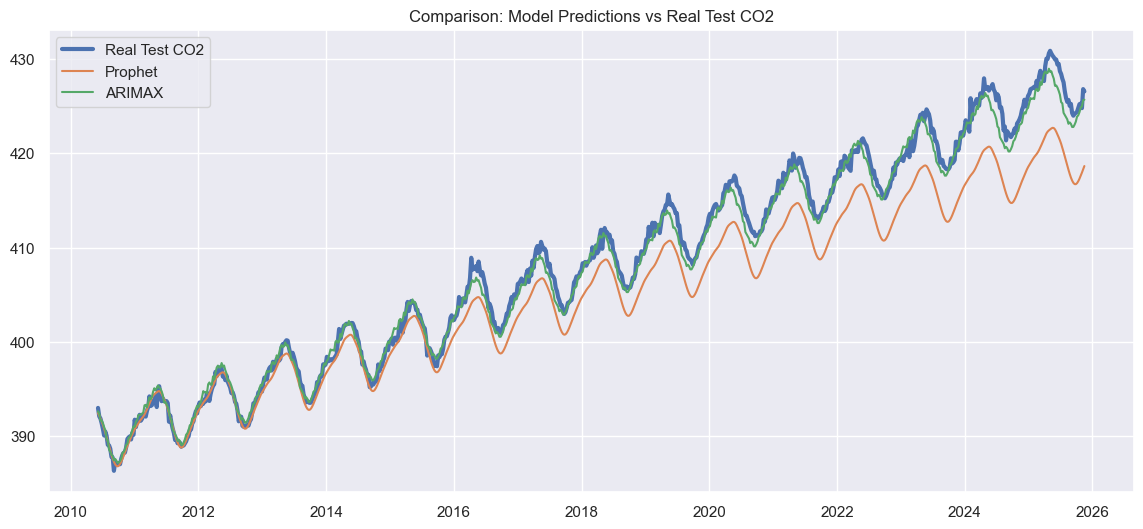

In [542]:
plt.figure(figsize=(14,6))
# plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Real Test CO2", linewidth=3)
plt.plot(test.index, fut_pred, label="Prophet")
plt.plot(test.index, arimax_pred, label="ARIMAX")

plt.legend()
plt.title("Comparison: Model Predictions vs Real Test CO2")
plt.show()

# LSTM Model

In [207]:
import tensorflow as tf
from tensorflow.keras import layers ,Sequential
from sklearn.preprocessing import MinMaxScaler

In [255]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))

In [209]:
window=365
def create_sequences(arr):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    return np.array(X), np.array(y)

x_train, y_train = create_sequences(train_scaled)

In [210]:
x_train.shape

(1516, 365, 1)

In [211]:
train_scaled.shape

(1881, 1)

In [247]:
model=Sequential([
    layers.Input(shape=(window,1)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1)
])

In [248]:
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [249]:
from tensorflow.keras.callbacks import EarlyStopping
early=EarlyStopping(patience=5, restore_best_weights=True)
model.fit(x_train,y_train,verbose=1,
          epochs=20,
          batch_size=64,
         callbacks=[early])

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 0.0436 - mae: 0.1555
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0022 - mae: 0.0356    
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 6.6429e-04 - mae: 0.0206
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 3.4716e-04 - mae: 0.0147
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 2.6906e-04 - mae: 0.0130
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 2.5192e-04 - mae: 0.0127
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 2.4424e-04 - mae: 0.0126
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 2.3624e-04 - mae: 0.0124
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 2.2890e-04 - mae: 0.0122
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 2.2178e-04 - mae: 0.0120
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 2.1646e-04 - mae: 0.0119
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 2.0818

In [250]:
# iterative forecasting
preds = []
current_input = train_scaled[-window:].reshape(1,window,1)
for _ in range(len(test)):
    pred = model.predict(current_input, verbose=0)[0,0]
    preds.append(pred)
    new_input = np.append(current_input.flatten()[1:], pred).reshape(1,window,1)
    current_input = new_input

In [251]:
lstm_pred = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

In [252]:
evaluate(test, lstm_pred)

(np.float64(1.8611789809692239),
 1.567609468481355,
 np.float64(0.38526721030988986),
 0.973249601996346)

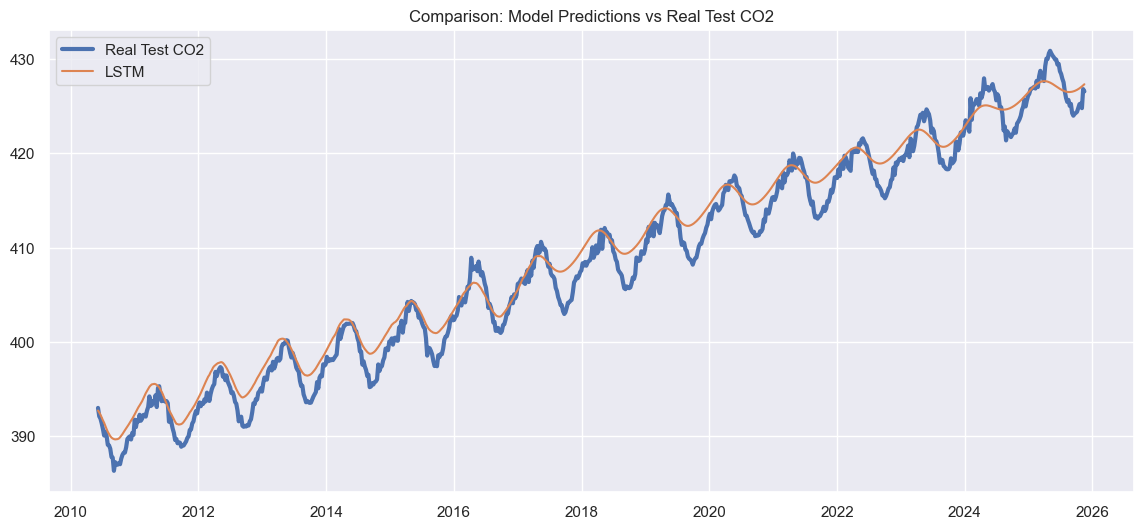

In [253]:
plt.figure(figsize=(14,6))
# plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Real Test CO2", linewidth=3)
plt.plot(test.index, lstm_pred, label="LSTM")
# plt.plot(test.index, arimax_pred, label="ARIMAX")
plt.legend()
plt.title("Comparison: Model Predictions vs Real Test CO2")
plt.show()

- ETS Models ,use Prohet model,do analysis
- fine tuning
1. Since we have relatively small number of features, we were not worried about overfitting with the residual model using linear regression. However, overfitting becomes a problem with more features and more complicate models. Chose a different model than linear regression and tune the model's hyperparameters. You may need to use `TimeSeriesSplit` in conjunction with `GridSearchCV` to properly tune the model.

# Improvement on LSTM

In [256]:
from statsmodels.tsa.seasonal import MSTL

In [258]:
y=co2.copy()

In [259]:
decomp=MSTL(y,periods=[365]).fit()

In [276]:
trend=decomp.trend
season=decomp.seasonal
resd=y-trend-season

In [289]:
train_resd,test_resd=resd.iloc[:train_size],resd.iloc[train_size:]

In [291]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_resd.values.reshape(-1,1))
test_scaled  = scaler.transform(test_res.values.reshape(-1,1))

In [296]:
x_train,y_train=create_sequences(train_scaled)

In [307]:
model = Sequential([
    layers.Input(shape=(window,1)),
    # layers.Bidirectional(layers.LSTM(32)),
    layers.LSTM(32),
    layers.Dense(1)
])

In [308]:
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [309]:
from tensorflow.keras.callbacks import EarlyStopping
early=EarlyStopping(patience=5, restore_best_weights=True)
model.fit(x_train,y_train,verbose=1,
          epochs=20,
          batch_size=64,
         callbacks=[early])

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.1307 - mae: 0.2920
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0204 - mae: 0.1140
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0169 - mae: 0.1020
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0167 - mae: 0.1014 
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0166 - mae: 0.1007 
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0164 - mae: 0.1003
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0162 - mae: 0.0997
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0161 - mae: 0.0996 
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0161 - mae: 0.0992
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0160 - mae: 0.0986
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0158 - mae: 0.0982
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0158 - mae: 0.0981 
Epoch 13/20
24/24 ━━━━━━━━

In [310]:
# iterative forecasting
preds = []
current_input = train_scaled[-window:].reshape(1,window,1)
for _ in range(len(test)):
    pred = model.predict(current_input, verbose=0)[0,0]
    preds.append(pred)
    new_input = np.append(current_input.flatten()[1:], pred)
    current_input = new_input.reshape(1,window,1)

In [315]:
lstm_pred = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

In [316]:
# reconstruct co2 forecast
final_pred=trend.iloc[-len(test):]  +season.iloc[-len(test):]  +lstm_pred

In [317]:
evaluate(test, final_pred)

(np.float64(0.5565526401435453),
 0.44627969502006765,
 np.float64(0.10991399530166691),
 0.9976079708702925)

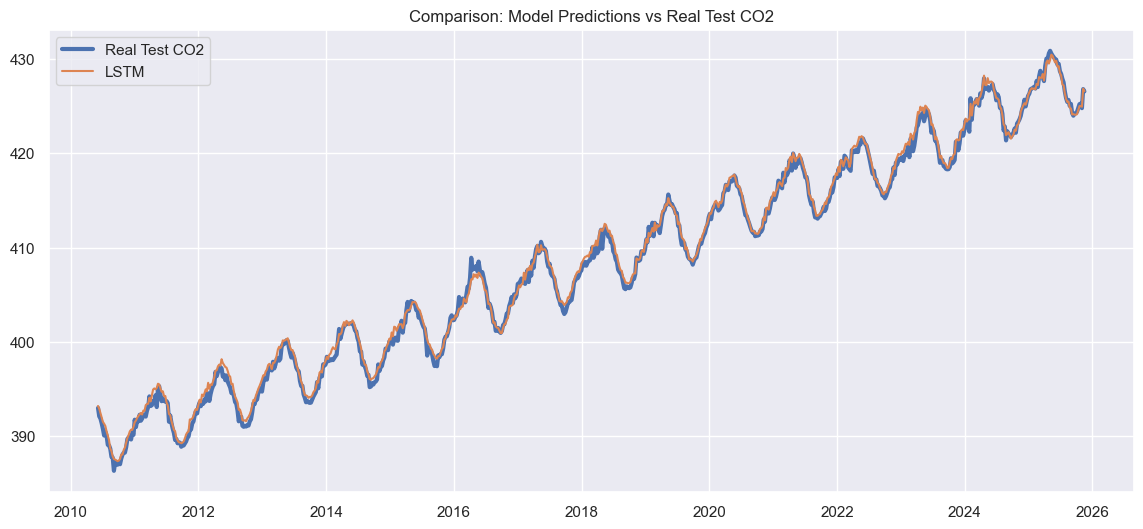

In [318]:
plt.figure(figsize=(14,6))
# plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Real Test CO2", linewidth=3)
plt.plot(test.index, final_pred, label="LSTM")
# plt.plot(test.index, arimax_pred, label="ARIMAX")
plt.legend()
plt.title("Comparison: Model Predictions vs Real Test CO2")
plt.show()